In [1]:
import json
from glob import glob
from itertools import product
from pathlib import Path

import h5py
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

path = Path.cwd()
root_path = list(path.parents)[1]
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[path.parent / "figures" / 'fonts'], fontext='ttf')
matplotlib.font_manager.fontManager.addfont(font_files[0])

# specify matplotlib rc file
plt.style.use(root_path / ".matplotlibrc")
mpl.rcParams['font.family'] = 'Arial'

../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[0.1036859  0.09385974 0.06262078]
 [0.09681911 0.08878412 0.05388863]
 [0.08461872 0.11338882 0.05543312]
 [0.20167905 0.09559633 0.04930538]
 [0.267681   0.11732858 0.04388031]
 [0.14257434 0.08696766 0.05077447]
 [0.07185977 0.07956398 0.06768074]
 [0.19031131 0.08062549 0.04443227]
 [0.0228008  0.1563421  0.05420134]
 [0.24144621 0.41688821 0.52759367]]
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[ 4.02956676  0.8494131   0.68391865]
 [ 9.11606598  0.81193507  0.75564063]
 [26.54862022  0.69314563  0.66831225]
 [ 2.44931054  0.53664249  0.6113627 ]
 [ 9.71305847  0.72651112  0.76230127]
 [15.80575466  0.70951635  0.70694399]
 [79.16098785  0.87757

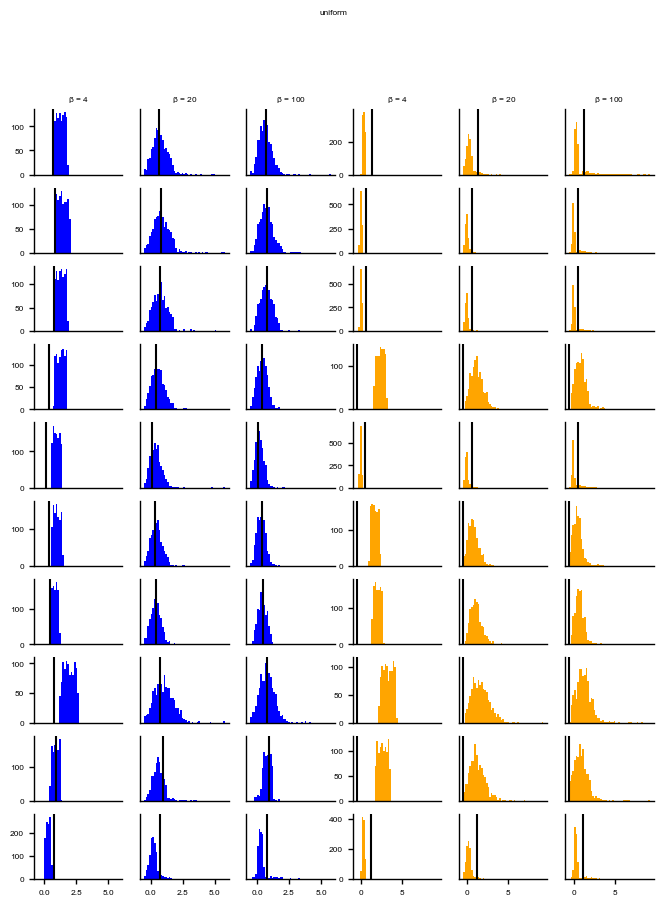

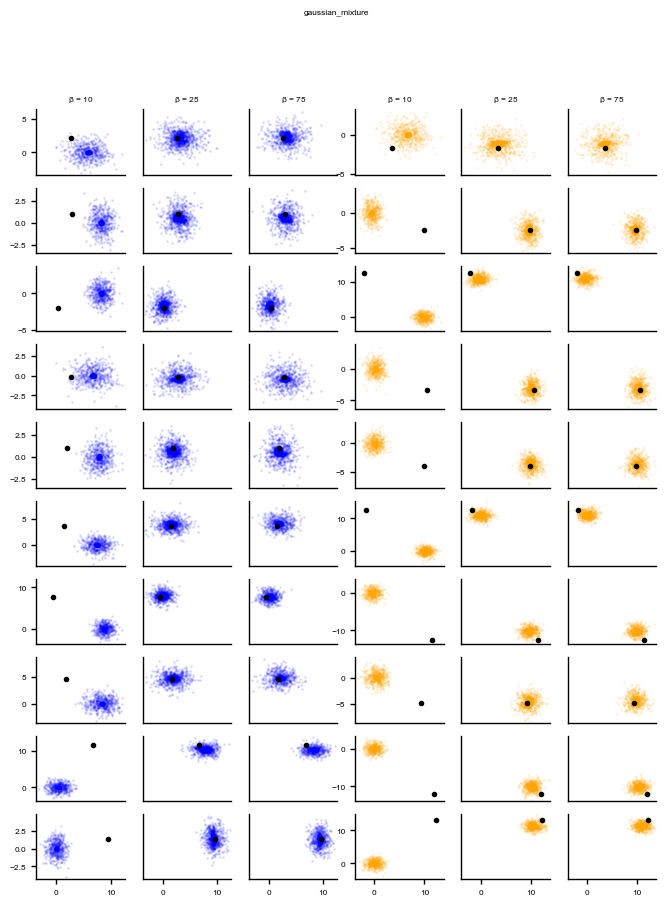

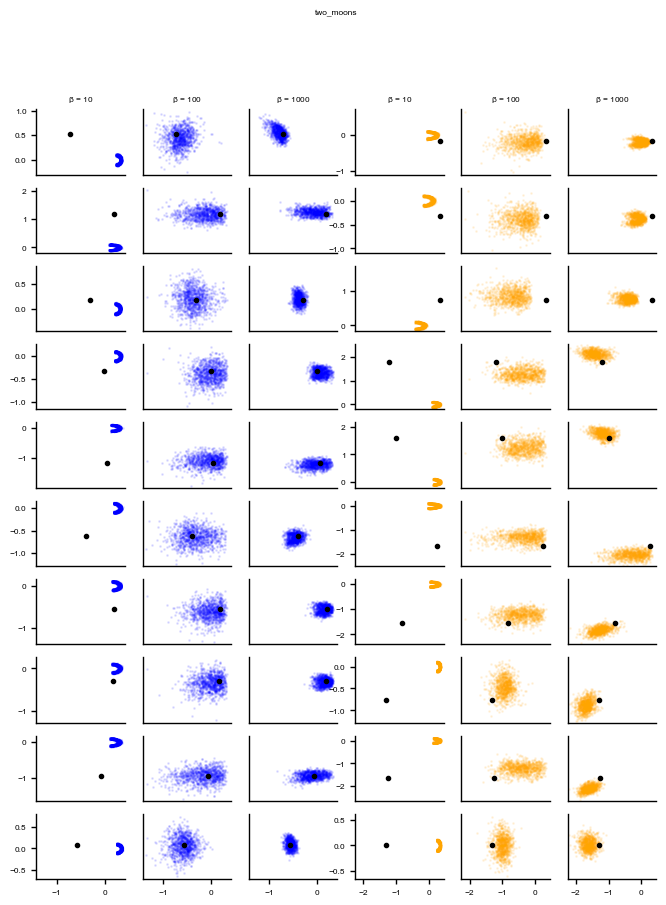

In [2]:
res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob(
    "*/lightning_logs/version_0/*/specified_unknown_evaluate_samples.h5"
):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    fig, axes = plt.subplots(
        ncols=len(attrs["betas"]) * 2,
        nrows=len(attrs["x_o"]),
        figsize=(8, 10),
        # sharex="row",
        # sharey="row",
    )
    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    
    res = np.zeros((len(attrs["x_o"]), len(attrs["betas"])))
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="b")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="b", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
        res[row, col] = np.mean(np.square(content["x_pred"][col, :, row] - attrs["x_o"][row]))

        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())
    print(res)
    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])
        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])
        if row == 0:
            ax.set_title(fr"$\beta$ = {attrs["betas"][col]}")
            axes[row, col + 3].set_title(fr"$\beta$ = {attrs["betas"][col]}")

    

    # plot second half
    res_path = res_path.parent / Path("mis" + str(res_path.name))
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="orange")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="orange", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
    
        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())

    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])

        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])   
            
    task = list(res_path.parents)[3].name
    fig.suptitle(task)
    # fig.tight_layout()  

In [3]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd 

res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob("*/lightning_logs/version_0/*/*_unknown_evaluate_samples.h5"):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    # for key, value in content.attrs.items():
    #     print(key, value)
    # content = torch.load(res_path)
    
    x_o = attrs["x_o"] if "x_o" in attrs.keys() else content["x_o"]
    
    # print(content["x_pred"].shape)
    # print(content["theta"][0] == content["theta"][1])
    # print(content["x_pred"][0] == content["x_pred"][1])
    mse = np.mean(np.square((content["x_pred"] - x_o[None, None,])), axis=(1, 3))# .detach()
    specified, known, _, _ = res_path.stem.split("_")
    task = list(res_path.parents)[3].name
    # task = res_path.parents[]
    data = {
        "task": task,
        "specified": specified,
        "known": known,
        "betas": content.attrs["betas"],
        "mse": mse.tolist(),
        # "mse_mean": np.median(mse,-1),
        # "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
    content.close()
df = pd.concat(dfs)
df = df.set_index(["task", "specified", "known", "betas"])
df.sort_index()


../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_un

mse
task             specified    known   betas                                                   
gaussian_mixture misspecified unknown 10     [2.907113790512085, 51.5093879699707, 151.0307...
                                      25     [0.7381895184516907, 0.669698178768158, 3.3197...
                                      75     [0.6748082637786865, 0.6055099964141846, 3.174...
                 specified    unknown 10     [4.029568195343018, 9.116064071655273, 26.5486...
                                      25     [0.8494131565093994, 0.8119350671768188, 0.693...
                                      75     [0.6839190721511841, 0.7556403279304504, 0.668...
linear_gaussian  misspecified unknown 1      [11.84200668334961, 11.024544715881348, 14.928...
                                      10     [12.979187965393066, 11.876322746276855, 15.68...
                                      100    [12.532159805297852, 11.841053009033203, 15.28...
                 specified    unknown 1      [2.9155666828155518, 2.278885841369629, 1.8211...
                                      10     [3.883824586868286, 3.1506567001342773, 2.6965...
                                      100    [3.356266736984253, 2.3946354389190674, 2.1508...
two_moons        misspecified unknown 10     [0.018189769238233566, 0.06309609860181808, 0....
                                      100    [0.04971809685230255, 0.05571136996150017, 0.1...
                                      1000   [0.012600948102772236, 0.017529286444187164, 0...
                 specified    unknown 10     [0.6635597944259644, 0.6901608109474182, 0.173...
                                      100    [0.040003418922424316, 0.040550220757722855, 0...
                                      1000   [0.01574321649968624, 0.023044787347316742, 0....
uniform          misspecified unknown 4      [0.8438789248466492, 0.8693050146102905, 0.829...
                                      20     [1.1359087228775024, 1.1719695329666138, 1.189...
                                      100    [1.4910277128219604, 1.694908857345581, 1.6987...
                 specified    unknown 4      [0.1036858931183815, 0.09681914001703262, 0.08...
                                      20     [0.09385974705219269, 0.08878415077924728, 0.1...
                                      100    [0.06262074410915375, 0.053888626396656036, 0....

uniform specified
           mean       std
beta                     
4.0    0.094360  0.077540
20.0   0.049991  0.027078
100.0  0.027609  0.002308


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


uniform misspecified
           mean       std
beta                     
4.0    0.531265  0.286665
20.0   0.151899  0.036086
100.0  0.108193  0.025069


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons specified
            mean       std
beta                      
10.0    0.081393  0.013825
100.0   0.017173  0.003511
1000.0  0.006345  0.001873


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons misspecified
            mean       std
beta                      
10.0    0.227978  0.113898
100.0   0.127735  0.111917
1000.0  0.115481  0.112072


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian specified
           mean       std
beta                     
1.0    3.731448  0.852989
10.0   1.653358  0.233905
100.0  0.990434  0.101110


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian misspecified
            mean       std
beta                      
1.0    11.687236  2.797506
10.0    3.755213  0.802263
100.0   1.768628  0.461014


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture specified
          mean       std
beta                    
10.0  0.104372  0.009963
25.0  0.046866  0.004195
75.0  0.024143  0.002446


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture misspecified
          mean       std
beta                    
10.0  0.259122  0.063547
25.0  0.208299  0.075941
75.0  0.184428  0.083844


/tmp/ipykernel_7200/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


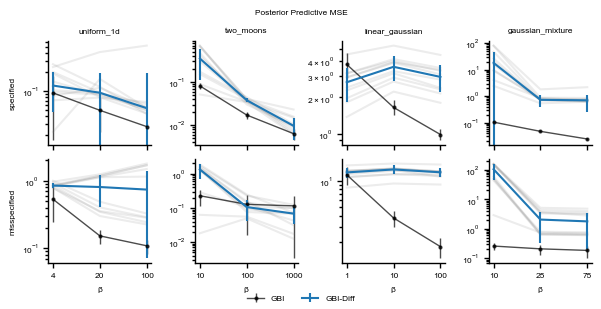

In [4]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(6, 3), sharex="col")
datasets = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_specified = ["specified", "misspecified"]


for col_idx, dataset in enumerate(datasets):
    df_summaries = pd.read_csv(f"GBI_results_{datasets[col_idx]}.csv")
    for row_idx, specified in enumerate(is_specified):
        ax = axs[row_idx, col_idx]

        if row_idx == 0:
            ax.set_title(dataset)
        elif row_idx == 1:
            ax.set_xlabel(r"$\beta$")

        if col_idx == 0:
            ax.set_ylabel(specified)

        df_collapsed = df_summaries.groupby(
            ["algorithm", "beta", "xo_specified", "xo_known"]
        ).describe()
        df_cur = df_collapsed.loc["GBI", :, specified, "unknown"]["dist_samples_mean"]
        gbi_line = ax.errorbar(
            df_cur.index.astype(int).astype(str),
            df_cur["mean"].values,
            yerr=df_cur["std"].values,
            fmt="-o",
            label="GBI",
            lw=1,
            alpha=0.7,
            markersize=2,
        )

        tmp_dataset = dataset
        if dataset == "uniform_1d":
            tmp_dataset = "uniform"
        print(tmp_dataset, specified)
        print(df_cur[["mean", "std"]])
        tmp_df = df.loc[tmp_dataset, specified, "unknown"]
        # tmp_df = df[(df["task"] == tmp_dataset) & (df["specified"] == specified)]
        mse = np.array(tmp_df["mse"].to_list())
        ax.plot(tmp_df.index.astype(str), mse, color="grey", alpha=0.15)
        gbi_diff_line = ax.errorbar(
            tmp_df.index.astype(str),
            np.median(mse, axis=1),
            np.std(mse, axis=1),
            label="GBI-Diff",
        )
        ax.set_yscale("log")

fig.suptitle("Posterior Predictive MSE")
fig.legend((gbi_line, gbi_diff_line), ("GBI", "GBI-Diff"), loc="lower center", ncol=2)
fig.tight_layout()

In [ ]:
    import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd 

res_base_path = Path("../../results_normalized/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob("*/lightning_logs/version_0/*/*evaluate_samples.h5"):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    # for key, value in content.attrs.items():
    #     print(key, value)
    # content = torch.load(res_path)
    
    x_o = attrs["x_o"] if "x_o" in attrs.keys() else content["x_o"]
    if "gaussian_mixture" in str(res_path):
        print(attrs["theta_o"].reshape((10, 5, 2)))
    # print(content["x_pred"].shape)
    # print(content["theta"][0] == content["theta"][1])
    # print(content["x_pred"][0] == content["x_pred"][1])
    mse = np.mean(np.square((content["x_pred"] - x_o[None, None,])), axis=(1, 3))# .detach()
    specified, known, _, _ = res_path.stem.split("_")
    task = list(res_path.parents)[3].name
    # task = res_path.parents[]
    data = {
        "task": task,
        "specified": specified,
        "known": known,
        "betas": content.attrs["betas"],
        "mse": mse.tolist(),
        # "mse_mean": np.median(mse,-1),
        # "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
    content.close()
df = pd.concat(dfs)
df = df.set_index(["task", "specified", "known", "betas"])
df.sort_index()

../../results_normalized/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
../../results_normalized/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results_normalized/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=94-step=3800/misspecified_unknown_evaluate_samples.h5
../../results_normalized/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=94-step=3800/specified_unknown_evaluate_samples.h5
../../results_normalized/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
[[[-3.4431243  -4.788059  ]
  [-8.138274    8.385071  ]
  [-4.001871    2.6497946 ]
  [-3.4696589   0.81261253]
  [ 9.323004    4.6072273 ]]

 [[-8.665997    3.9690285 ]
  [ 9.492428    2.6308336 ]
  [ 6.7042465   9.858875  ]
  [-1.5322895   2.0755444 ]
  [-6.9503508  -2.060771  ]]

 [[-3.4431243  -4

mse
task             specified    known   betas                                                   
gaussian_mixture misspecified unknown 10     [51.62800598144531, 155.2388458251953, 140.122...
                                      25     [2.2074570655822754, 4.84037446975708, 4.94942...
                                      75     [1.3988429307937622, 2.3520519733428955, 2.203...
                 specified    unknown 10     [22.83656883239746, 67.96263885498047, 13.2603...
                                      25     [2.013801097869873, 2.1973869800567627, 2.5705...
                                      75     [1.3773913383483887, 1.3901115655899048, 1.525...
linear_gaussian  misspecified unknown 1      [11.84200668334961, 11.024544715881348, 14.928...
                                      10     [12.553900718688965, 11.858125686645508, 16.07...
                                      100    [11.888877868652344, 11.447482109069824, 15.46...
                 specified    unknown 1      [2.9155666828155518, 2.278885841369629, 1.8211...
                                      10     [3.829641103744507, 3.2122042179107666, 2.7042...
                                      100    [3.371999979019165, 2.5698161125183105, 2.1052...
two_moons        misspecified unknown 10     [0.017946235835552216, 0.0633125752210617, 0.2...
                                      100    [0.017968928441405296, 0.025878028944134712, 0...
                                      1000   [0.007830346934497356, 0.013484765775501728, 0...
                 specified    unknown 10     [0.6651907563209534, 0.6884149312973022, 0.174...
                                      100    [0.016113540157675743, 0.017665749415755272, 0...
                                      1000   [0.01088283397257328, 0.023697510361671448, 0....
uniform          misspecified unknown 4      [0.8438789248466492, 0.8693050146102905, 0.829...
                                      20     [2.4535233974456787, 2.4114513397216797, 2.304...
                                      100    [326.39202880859375, 333.7792663574219, 320.39...
                 specified    unknown 4      [0.1036858931183815, 0.09681914001703262, 0.08...
                                      20     [0.047034140676259995, 0.04485723748803139, 0....
                                      100    [0.024523653090000153, 0.024995969608426094, 0...

uniform specified
           mean       std
beta                     
4.0    0.094360  0.077540
20.0   0.049991  0.027078
100.0  0.027609  0.002308
           mean       std
betas                    
4      0.142348  0.075835
20     0.091049  0.133327
100    2.161102  6.368412


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


uniform misspecified
           mean       std
beta                     
4.0    0.531265  0.286665
20.0   0.151899  0.036086
100.0  0.108193  0.025069
             mean         std
betas                        
4        0.866924    0.069643
20       1.254069    1.090913
100    172.326950  175.435580


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons specified
            mean       std
beta                      
10.0    0.081393  0.013825
100.0   0.017173  0.003511
1000.0  0.006345  0.001873
           mean       std
betas                    
10     0.369228  0.240249
100    0.014147  0.001929
1000   0.008271  0.005580


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons misspecified
            mean       std
beta                      
10.0    0.227978  0.113898
100.0   0.127735  0.111917
1000.0  0.115481  0.112072
           mean       std
betas                    
10     1.083984  0.653238
100    0.059446  0.041354
1000   0.035829  0.021417


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian specified
           mean       std
beta                     
1.0    3.731448  0.852989
10.0   1.653358  0.233905
100.0  0.990434  0.101110
           mean       std
betas                    
1      2.648652  0.838968
10     3.521750  0.839690
100    2.907636  0.712425


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian misspecified
            mean       std
beta                      
1.0    11.687236  2.797506
10.0    3.755213  0.802263
100.0   1.768628  0.461014
            mean       std
betas                     
1      12.076017  1.650103
10     12.902077  1.767136
100    11.700056  1.769688


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture specified
          mean       std
beta                    
10.0  0.104372  0.009963
25.0  0.046866  0.004195
75.0  0.024143  0.002446
            mean        std
betas                      
10     36.562306  24.715421
25      2.238097   0.276968
75      1.346528   0.166023


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture misspecified
          mean       std
beta                    
10.0  0.259122  0.063547
25.0  0.208299  0.075941
75.0  0.184428  0.083844
            mean        std
betas                      
10     89.011359  60.154867
25      3.614171   1.601172
75      1.793202   0.558627


/tmp/ipykernel_7200/2452622202.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


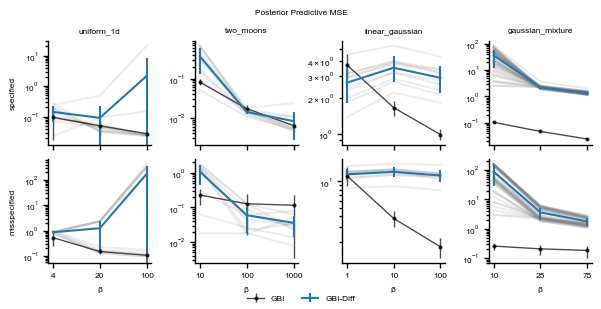

In [6]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(6, 3), sharex="col")
datasets = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_specified = ["specified", "misspecified"]


for col_idx, dataset in enumerate(datasets):
    df_summaries = pd.read_csv(f"GBI_results_{datasets[col_idx]}.csv")
    for row_idx, specified in enumerate(is_specified):
        ax = axs[row_idx, col_idx]

        if row_idx == 0:
            ax.set_title(dataset)
        elif row_idx == 1:
            ax.set_xlabel(r"$\beta$")

        if col_idx == 0:
            ax.set_ylabel(specified)

        df_collapsed = df_summaries.groupby(
            ["algorithm", "beta", "xo_specified", "xo_known"]
        ).describe()
        df_cur = df_collapsed.loc["GBI", :, specified, "unknown"]["dist_samples_mean"]
        gbi_line = ax.errorbar(
            df_cur.index.astype(int).astype(str),
            df_cur["mean"].values,
            yerr=df_cur["std"].values,
            fmt="-o",
            label="GBI",
            lw=1,
            alpha=0.7,
            markersize=2,
        )

        tmp_dataset = dataset
        if dataset == "uniform_1d":
            tmp_dataset = "uniform"
        print(tmp_dataset, specified)
        print(df_cur[["mean", "std"]])

        try:
            tmp_df = df.loc[tmp_dataset, specified, "unknown"]
        except KeyError:
            continue
        # tmp_df = df[(df["task"] == tmp_dataset) & (df["specified"] == specified)]
        mse = np.array(tmp_df["mse"].to_list())
        print(pd.DataFrame(index=tmp_df.index, data=np.stack([mse.mean(1), mse.std(1)]).T, columns=("mean", "std")))
        ax.plot(tmp_df.index.astype(str), mse, color="grey", alpha=0.15)
        gbi_diff_line = ax.errorbar(
            tmp_df.index.astype(str),
            np.mean(mse, axis=1),
            np.std(mse, axis=1),
            label="GBI-Diff",
        )
        ax.set_yscale("log")

fig.suptitle("Posterior Predictive MSE")
fig.legend((gbi_line, gbi_diff_line), ("GBI", "GBI-Diff"), loc="lower center", ncol=2)
fig.tight_layout()

../../results_normalized/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[ 0.1036859   0.04703412  0.02452364]
 [ 0.09681911  0.04485724  0.02499596]
 [ 0.08461872  0.05674836  0.02399567]
 [ 0.20167905  0.03171705  0.02278879]
 [ 0.267681    0.0333853   0.02506149]
 [ 0.14257434  0.03727251  0.02487529]
 [ 0.07185977  0.04537207  0.02528054]
 [ 0.19031131  0.03363258  0.02370824]
 [ 0.0228008   0.09270015  0.14978486]
 [ 0.24144621  0.48777285 21.26602173]]
../../results_normalized/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=94-step=3800/specified_unknown_evaluate_samples.h5
../../results_normalized/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[22.83658218  2.01380205  1.37739074]
 [67.96269226  2.19738793  1.39011228]
 [13.26033783  2.57059145  1.52599978]
 [ 6.03743219  2.36765409  1.4036206 ]
 [55.08356094  2.54119825  1.16727805

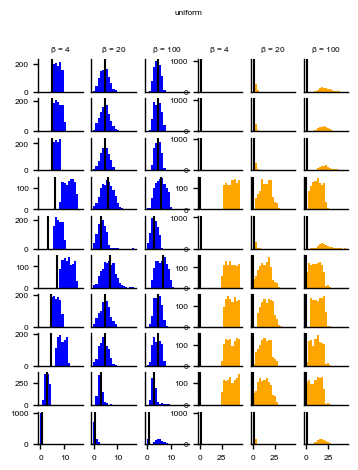

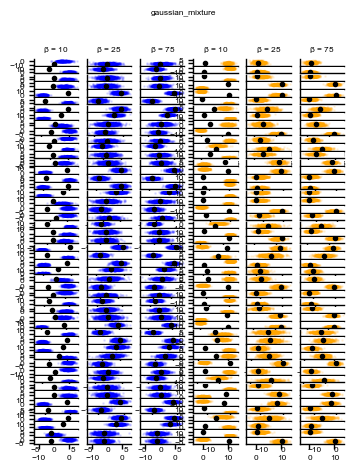

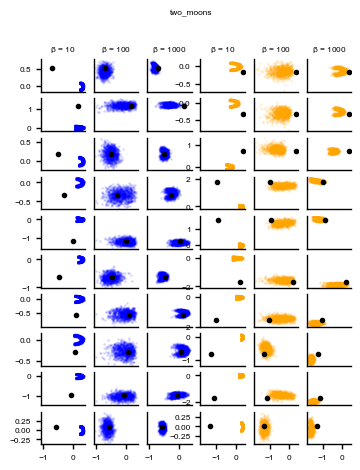

In [7]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd

res_base_path = Path("../../results_normalized/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob(
    "*/lightning_logs/version_0/*/specified_unknown_evaluate_samples.h5"
):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    fig, axes = plt.subplots(
        ncols=len(attrs["betas"]) * 2,
        nrows=len(attrs["x_o"]),
        figsize=(4, 5),
        # sharex="row",
        # sharey="row",
    )
    task = list(res_path.parents)[3].name
    fig.suptitle(task)
    
    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    
    res = np.zeros((len(attrs["x_o"]), len(attrs["betas"])))
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 20)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="b")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="b", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
        res[row, col] = np.mean(np.square(content["x_pred"][col, :, row] - attrs["x_o"][row]))

        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())
    print(res)
    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])
        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])
        if row == 0:
            ax.set_title(fr"$\beta$ = {attrs["betas"][col]}")
            axes[row, col + 3].set_title(fr"$\beta$ = {attrs["betas"][col]}")

    

    # plot second half
    res_path = res_path.parent / Path("mis" + str(res_path.name))
    try:
        content = h5py.File(res_path, "r")
    except FileNotFoundError:
        continue                
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 20)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="orange")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="orange", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
    
        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())

    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])

        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])   
            
    # fig.tight_layout() 

    

../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5


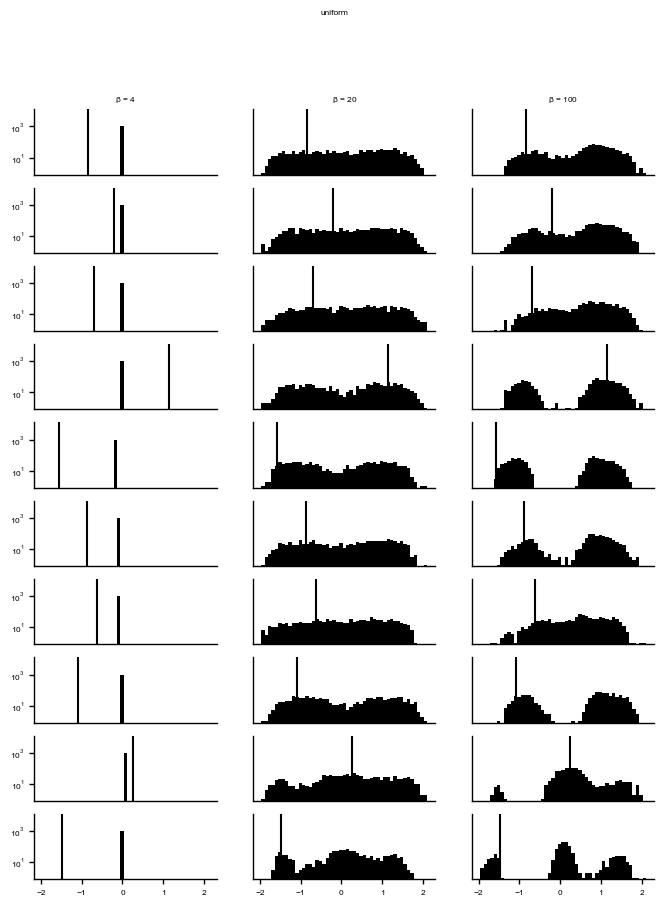

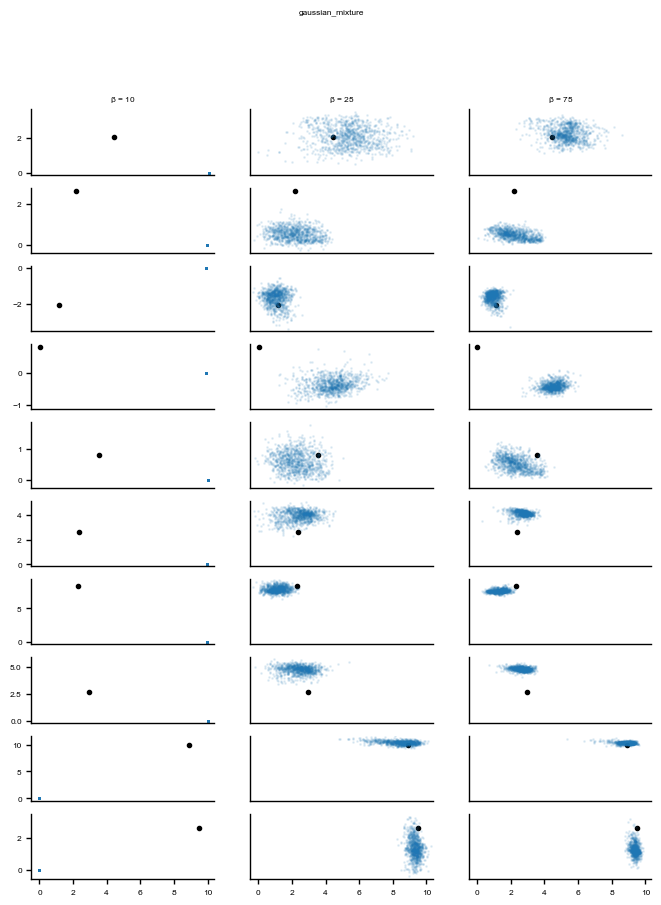

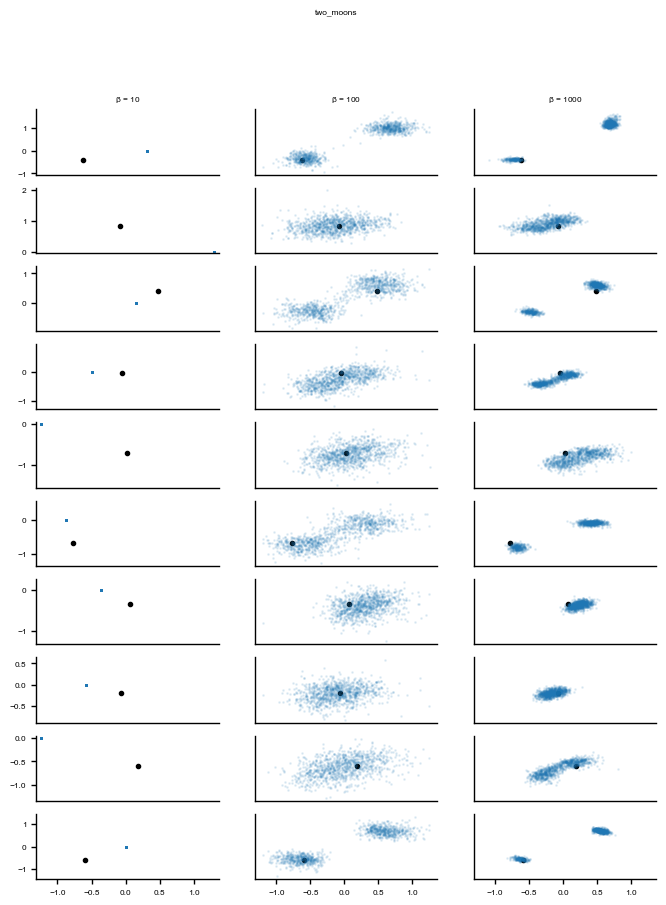

In [8]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd

res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob(
    "*/lightning_logs/version_0/*/specified_unknown_evaluate_samples.h5"
):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    theta_dim = attrs["theta_o"].shape[-1]
    if theta_dim > 2:
        continue

    fig, axes = plt.subplots(
        ncols=len(attrs["betas"]),
        nrows=len(attrs["theta_o"]),
        figsize=(8, 10),
        # sharex="row",
        # sharey="row",
    )

    x_lim = np.zeros((len(attrs["theta_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["theta_o"]), len(attrs["betas"]), 2))  
    
    limit_base = np.concatenate([content["theta"], attrs["theta_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    
    res = np.zeros((len(attrs["theta_o"]), len(attrs["betas"])))
    for row, col in np.ndindex(len(attrs["theta_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        if theta_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.axvline(attrs["theta_o"][row])
            ax.hist(content["theta"][col, :, row, 0], bins=bins)
            ax.set_yscale("log")
        elif theta_dim == 2:
            ax.scatter(*attrs["theta_o"][row])
            ax.scatter(*content["theta"][col, :, row].T, s=1, alpha=0.1)
        res[row, col] = np.mean(np.square(content["theta"][col, :, row] - attrs["theta_o"][row]))

        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())

    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["theta_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])
        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])
        if row == 0:
            ax.set_title(fr"$\beta$ = {attrs["betas"][col]}")
            axes[row, col].set_title(fr"$\beta$ = {attrs["betas"][col]}")
    task = list(res_path.parents)[3].name
    fig.suptitle(task)
    # fig.tight_layout()  

In [9]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
from gbi_diff.sampling.diffusion import DiffusionSampler

diff_ckpt = "../../results_normalized/diffusion/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
guidance_ckpt = "../../results_normalized/guidance/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
observed_data_file = "../../data/gbi_data/specified_unknown/two_moons_10.pt"

theta_pred = []
sampler = DiffusionSampler(diff_model_ckpt=diff_ckpt, guidance_model_ckpt=guidance_ckpt, observed_data_file=observed_data_file, beta=1000)
betas = [10, 100, 1000, 2000, 4000, 6000]
for beta in betas:
    sampler.update_beta(beta)
    theta_pred.append(sampler.single_forward(sampler.x_o[0], 1000))

two_moons two_moons


Step in diffusion process: 100%|██████████| 1000/1000 [00:21<00:00, 47.57it/s]


In [10]:
from gbi_diff.dataset.simulator_api import TwoMoonsSimulator

simulator = TwoMoonsSimulator()

x_pred = []
for theta in theta_pred:
    x_pred.append(simulator.sample(theta))

/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


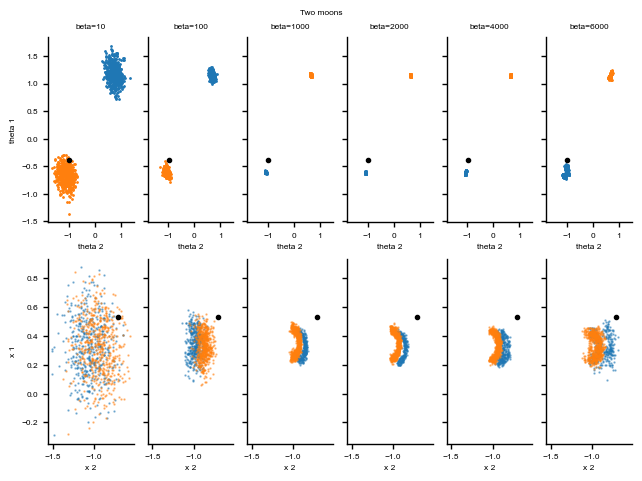

In [11]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

fig, ax = plt.subplots(nrows=2, ncols=len(x_pred), sharex="row", sharey="row")


for idx, (theta, x) in enumerate(zip(theta_pred, x_pred)):

    labels = KMeans(2).fit_predict(theta_pred[idx].detach().numpy()).astype(bool)
    ax[0, idx].scatter(*sampler.theta_o[0])
    # ax[0, idx].scatter(*theta_pred[idx].T.detach().numpy(), s=1, zorder=-1)
    ax[0, idx].scatter(*theta_pred[idx].detach().numpy()[labels].T, s=1, zorder=-1)
    ax[0, idx].scatter(*theta_pred[idx].detach().numpy()[~labels].T, s=1, zorder=-1)

    ax[1, idx].scatter(*sampler.x_o[0], label="GT")
    ax[1, idx].scatter(
        *x_pred[idx].detach().numpy()[labels].T,
        s=0.5,
        alpha=0.5,
        label="GBI-Diff",
        zorder=-1
    )
    ax[1, idx].scatter(
        *x_pred[idx].detach().numpy()[~labels].T,
        s=0.5,
        alpha=0.5,
        label="GBI-Diff",
        zorder=-1
    )
    
    ax[0, idx].set_xlabel("theta 2")
    ax[0, idx].set_title(f"beta={betas[idx]}")
    ax[1, idx].set_xlabel("x 2")

ax[0, 0].set_ylabel("theta 1")
ax[1, 0].set_ylabel("x 1")

# fig.legend(loc="lower center", ncols=2)
fig.suptitle("Two moons")
fig.tight_layout()

In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
from gbi_diff.sampling.diffusion import DiffusionSampler

diff_ckpt = "../../results_normalized/diffusion/gaussian_mixture/lightning_logs/version_0/epoch=89-step=3600.ckpt"
guidance_ckpt = "../../results_normalized/guidance/gaussian_mixture/lightning_logs/version_0/epoch=94-step=3800.ckpt"
observed_data_file = "../../data/gbi_data/specified_unknown/gaussian_mixture_50.pt"
            
theta_pred = []
sampler = DiffusionSampler(diff_model_ckpt=diff_ckpt, guidance_model_ckpt=guidance_ckpt, observed_data_file=observed_data_file, beta=1000)
betas = [10, 25, 75, 100, 150]
for beta in betas:
    sampler.update_beta(beta)
    theta_pred.append(sampler.single_forward(sampler.x_o[0], 1000))

gaussian_mixture gaussian_mixture


Step in diffusion process: 100%|██████████| 1000/1000 [00:19<00:00, 51.48it/s]


In [13]:
# sampler.update_beta(500)
# theta_pred.append(sampler.single_forward(sampler.x_o[0], 1000))

In [ ]:
from gbi_diff.dataset.simulators.gaussian_mixture import GaussianMixtureSimulator

simulator = GaussianMixtureSimulator()

x_pred = []
for theta in theta_pred:
    x_pred.append(simulator.simulate(theta))

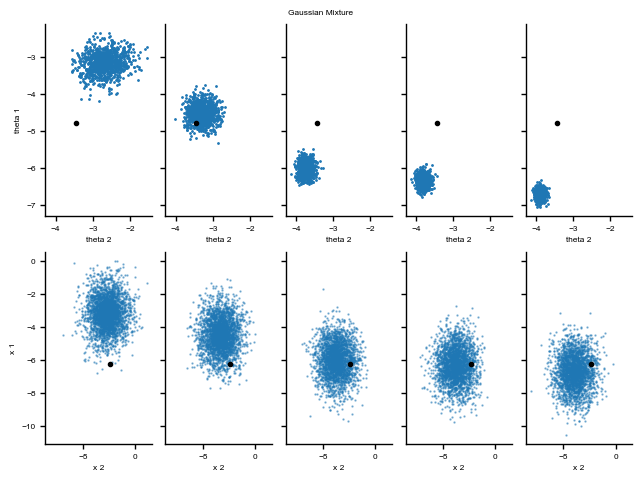

In [15]:
# file h5py.File("../../results_normalized/diffusion/two_moons/lightning_logs/version_0/epoch=94-step=3800/specified_unknown_evaluate_samples.h5")
# file.close()

fig, ax = plt.subplots(nrows=2, ncols=len(x_pred), sharex="row", sharey="row")


for idx, (theta, x) in enumerate(zip(theta_pred, x_pred)):

    ax[0, idx].scatter(*sampler.theta_o[0])
    ax[0, idx].scatter(*theta_pred[idx].T.detach().numpy(), s=1, zorder=-1)
    
    ax[1, idx].scatter(*sampler.x_o[0], label="GT")
    ax[1, idx].scatter(
        *x_pred[idx].detach().numpy().T,
        s=0.5,
        alpha=0.5,
        label="GBI-Diff",
        zorder=-1
    )
    
    ax[0, idx].set_xlabel("theta 2")
    # ax[0, idx].set_title(f"beta={betas[idx]}")
    ax[1, idx].set_xlabel("x 2")

ax[0, 0].set_ylabel("theta 1")
ax[1, 0].set_ylabel("x 1")

# fig.legend(loc="lower center", ncols=2)
fig.suptitle("Gaussian Mixture")
fig.tight_layout()

In [ ]:
simulator = GaussianMixtureSimulator(num_trials=1000)
prior = simulator.prior.sample((1000,))
posterior = simulator.simulate(prior)
prior.shape, posterior.shape
    
for i in range(5):
    plt.scatter(*posterior[i].T)

In [16]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
from gbi_diff.sampling.diffusion import DiffusionSampler

diff_ckpt = "../../results_normalized/diffusion/uniform/lightning_logs/version_0/epoch=89-step=3600.ckpt"
guidance_ckpt = "../../results_normalized/guidance/uniform/lightning_logs/version_0/epoch=99-step=4000.ckpt"
observed_data_file = "../../data/gbi_data/misspecified_unknown/uniform_10.pt"
            
theta_pred = []
sampler = DiffusionSampler(diff_model_ckpt=diff_ckpt, guidance_model_ckpt=guidance_ckpt, observed_data_file=observed_data_file, beta=1000)
betas = [1, 4, 20, 100, 500, 1000]
for beta in betas:
    sampler.update_beta(beta)
    theta_pred.append(sampler.single_forward(sampler.x_o[0], 1000))

uniform uniform


Step in diffusion process: 100%|██████████| 1000/1000 [00:17<00:00, 56.03it/s]


In [17]:
from gbi_diff.dataset.simulators.uniform import UniformNoise1DSimulator

simulator = UniformNoise1DSimulator()

x_pred = []
for theta in theta_pred:
    x_pred.append(simulator.simulate(theta))

In [18]:
theta_pred = torch.stack(theta_pred)
x_pred = torch.stack(x_pred)

0.07651011645793915 0.9417898058891296
0.47377434372901917 0.8668633103370667
0.23884066939353943 0.8229557871818542
0.6824303269386292 1.006920576095581
0.4351767599582672 0.7146820425987244
0.9191873073577881 1.5530246496200562
1.0543612241744995 0.9789096713066101
2.9427883625030518 3.1178293228149414
2.23850679397583 0.2436588704586029
8.531978607177734 1.7814631462097168
2.3534979820251465 0.08216572552919388
10.718228340148926 1.8598359823226929


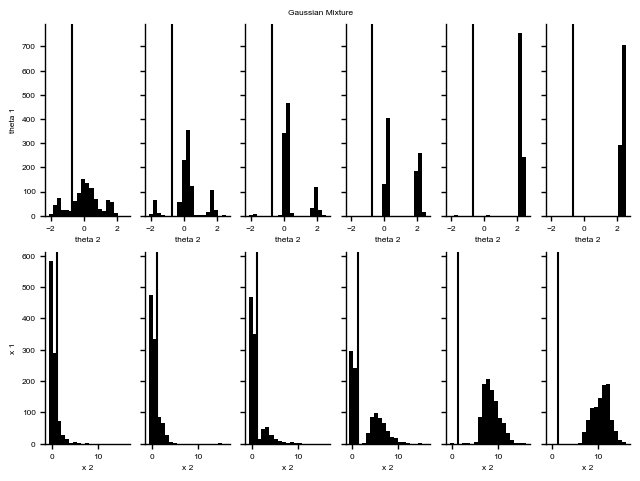

In [19]:
theta_lim = torch.tensor([torch.min(theta_pred[..., 0]).item(), torch.max(theta_pred[..., 0]).item()])
x_lim = torch.tensor([torch.min(x_pred[..., 0]).item(), torch.max(x_pred[..., 0]).item()])

fig, ax = plt.subplots(nrows=2, ncols=len(x_pred), sharex="row", sharey="row")


for idx, (theta, x) in enumerate(zip(theta_pred, x_pred)):

    ax[0, idx].axvline(sampler.theta_o[0])
    bins = np.linspace(*theta_lim.detach().numpy(), 20)
    ax[0, idx].hist(theta_pred[idx, ..., 0].detach().numpy(), bins)
    print(theta_pred[idx, ..., 0].mean().item(), theta_pred[idx, ..., 0].std().item())

    ax[1, idx].axvline(sampler.x_o[0])
    bins = np.linspace(*x_lim.detach().numpy(), 20)
    ax[1, idx].hist(x_pred[idx, ..., 0].detach().numpy(), bins)
    print(x_pred[idx, ..., 0].mean().item(), x_pred[idx, ..., 0].std().item())
    
    # ax[1, idx].scatter(*sampler.x_o[0], label="GT")
    # ax[1, idx].scatter(
    #     *x_pred[idx].detach().numpy().T,
    #     s=0.5,
    #     alpha=0.5,
    #     label="GBI-Diff",
    #     zorder=-1
    # )
    
    ax[0, idx].set_xlabel("theta 2")
    # ax[0, idx].set_title(f"beta={betas[idx]}")
    ax[1, idx].set_xlabel("x 2")

ax[0, 0].set_ylabel("theta 1")
ax[1, 0].set_ylabel("x 1")

# fig.legend(loc="lower center", ncols=2)
fig.suptitle("Gaussian Mixture")
fig.tight_layout()

In [20]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
from gbi_diff.sampling.diffusion import DiffusionSampler

diff_ckpt = "../../results_normalized/diffusion/linear_gaussian/lightning_logs/version_0/epoch=94-step=3800.ckpt"
guidance_ckpt = "../../results_normalized/guidance/linear_gaussian/lightning_logs/version_0/epoch=99-step=4000.ckpt"
observed_data_file = "../../data/gbi_data/specified_unknown/linear_gaussian_10.pt"
            
theta_pred = []
sampler = DiffusionSampler(diff_model_ckpt=diff_ckpt, guidance_model_ckpt=guidance_ckpt, observed_data_file=observed_data_file, beta=1000)
betas = [1, 10, 100, 1000, 10000]
for beta in betas:
    sampler.update_beta(beta)
    theta_pred.append(sampler.single_forward(sampler.x_o[0], 1000))     

linear_gaussian linear_gaussian


Step in diffusion process:  20%|██        | 204/1000 [00:03<00:14, 54.93it/s]

Step in diffusion process: 100%|██████████| 1000/1000 [00:18<00:00, 55.03it/s]


In [21]:
from gbi_diff.dataset.simulators.linear_gaussian import LinearGaussianSimulator

simulator = LinearGaussianSimulator()

x_pred = []
for theta in theta_pred:
    x_pred.append(simulator.simulate(theta))

In [22]:
theta_pred = torch.stack(theta_pred)
x_pred = torch.stack(x_pred)

             0         1         2         3         4         5         6  \
0     2.076287 -0.458206 -2.347589 -1.253166 -3.839128 -3.069126  3.403846   
1     1.074280 -0.262382 -2.916789 -0.037142 -3.126417 -3.258707  3.743984   
2     0.864977 -0.034840 -3.208838  0.192094 -3.942466 -3.439007  5.462280   
3     1.518174 -0.212997 -0.044371 -0.590753 -3.489994 -1.865667  4.067636   
4     3.025813 -0.451660 -4.448678  0.080208 -3.779761 -2.541453  5.092541   
...        ...       ...       ...       ...       ...       ...       ...   
996   1.058467 -0.184107 -2.625040 -0.495172 -2.024525 -2.993407  4.368245   
997   2.375499  0.171473 -3.292143  0.698662 -3.839993 -3.080420  4.439957   
998   1.255923 -0.185498 -2.992303  1.504155 -2.563222 -3.103698  3.809884   
999   2.242116  0.158035 -1.519150 -0.967022 -0.025993 -3.094872  4.407760   
1000  0.032727 -0.090230 -2.984100  0.076809 -2.469291 -0.085990  2.280639   

             7         8         9      kind  
0     0.013072 -

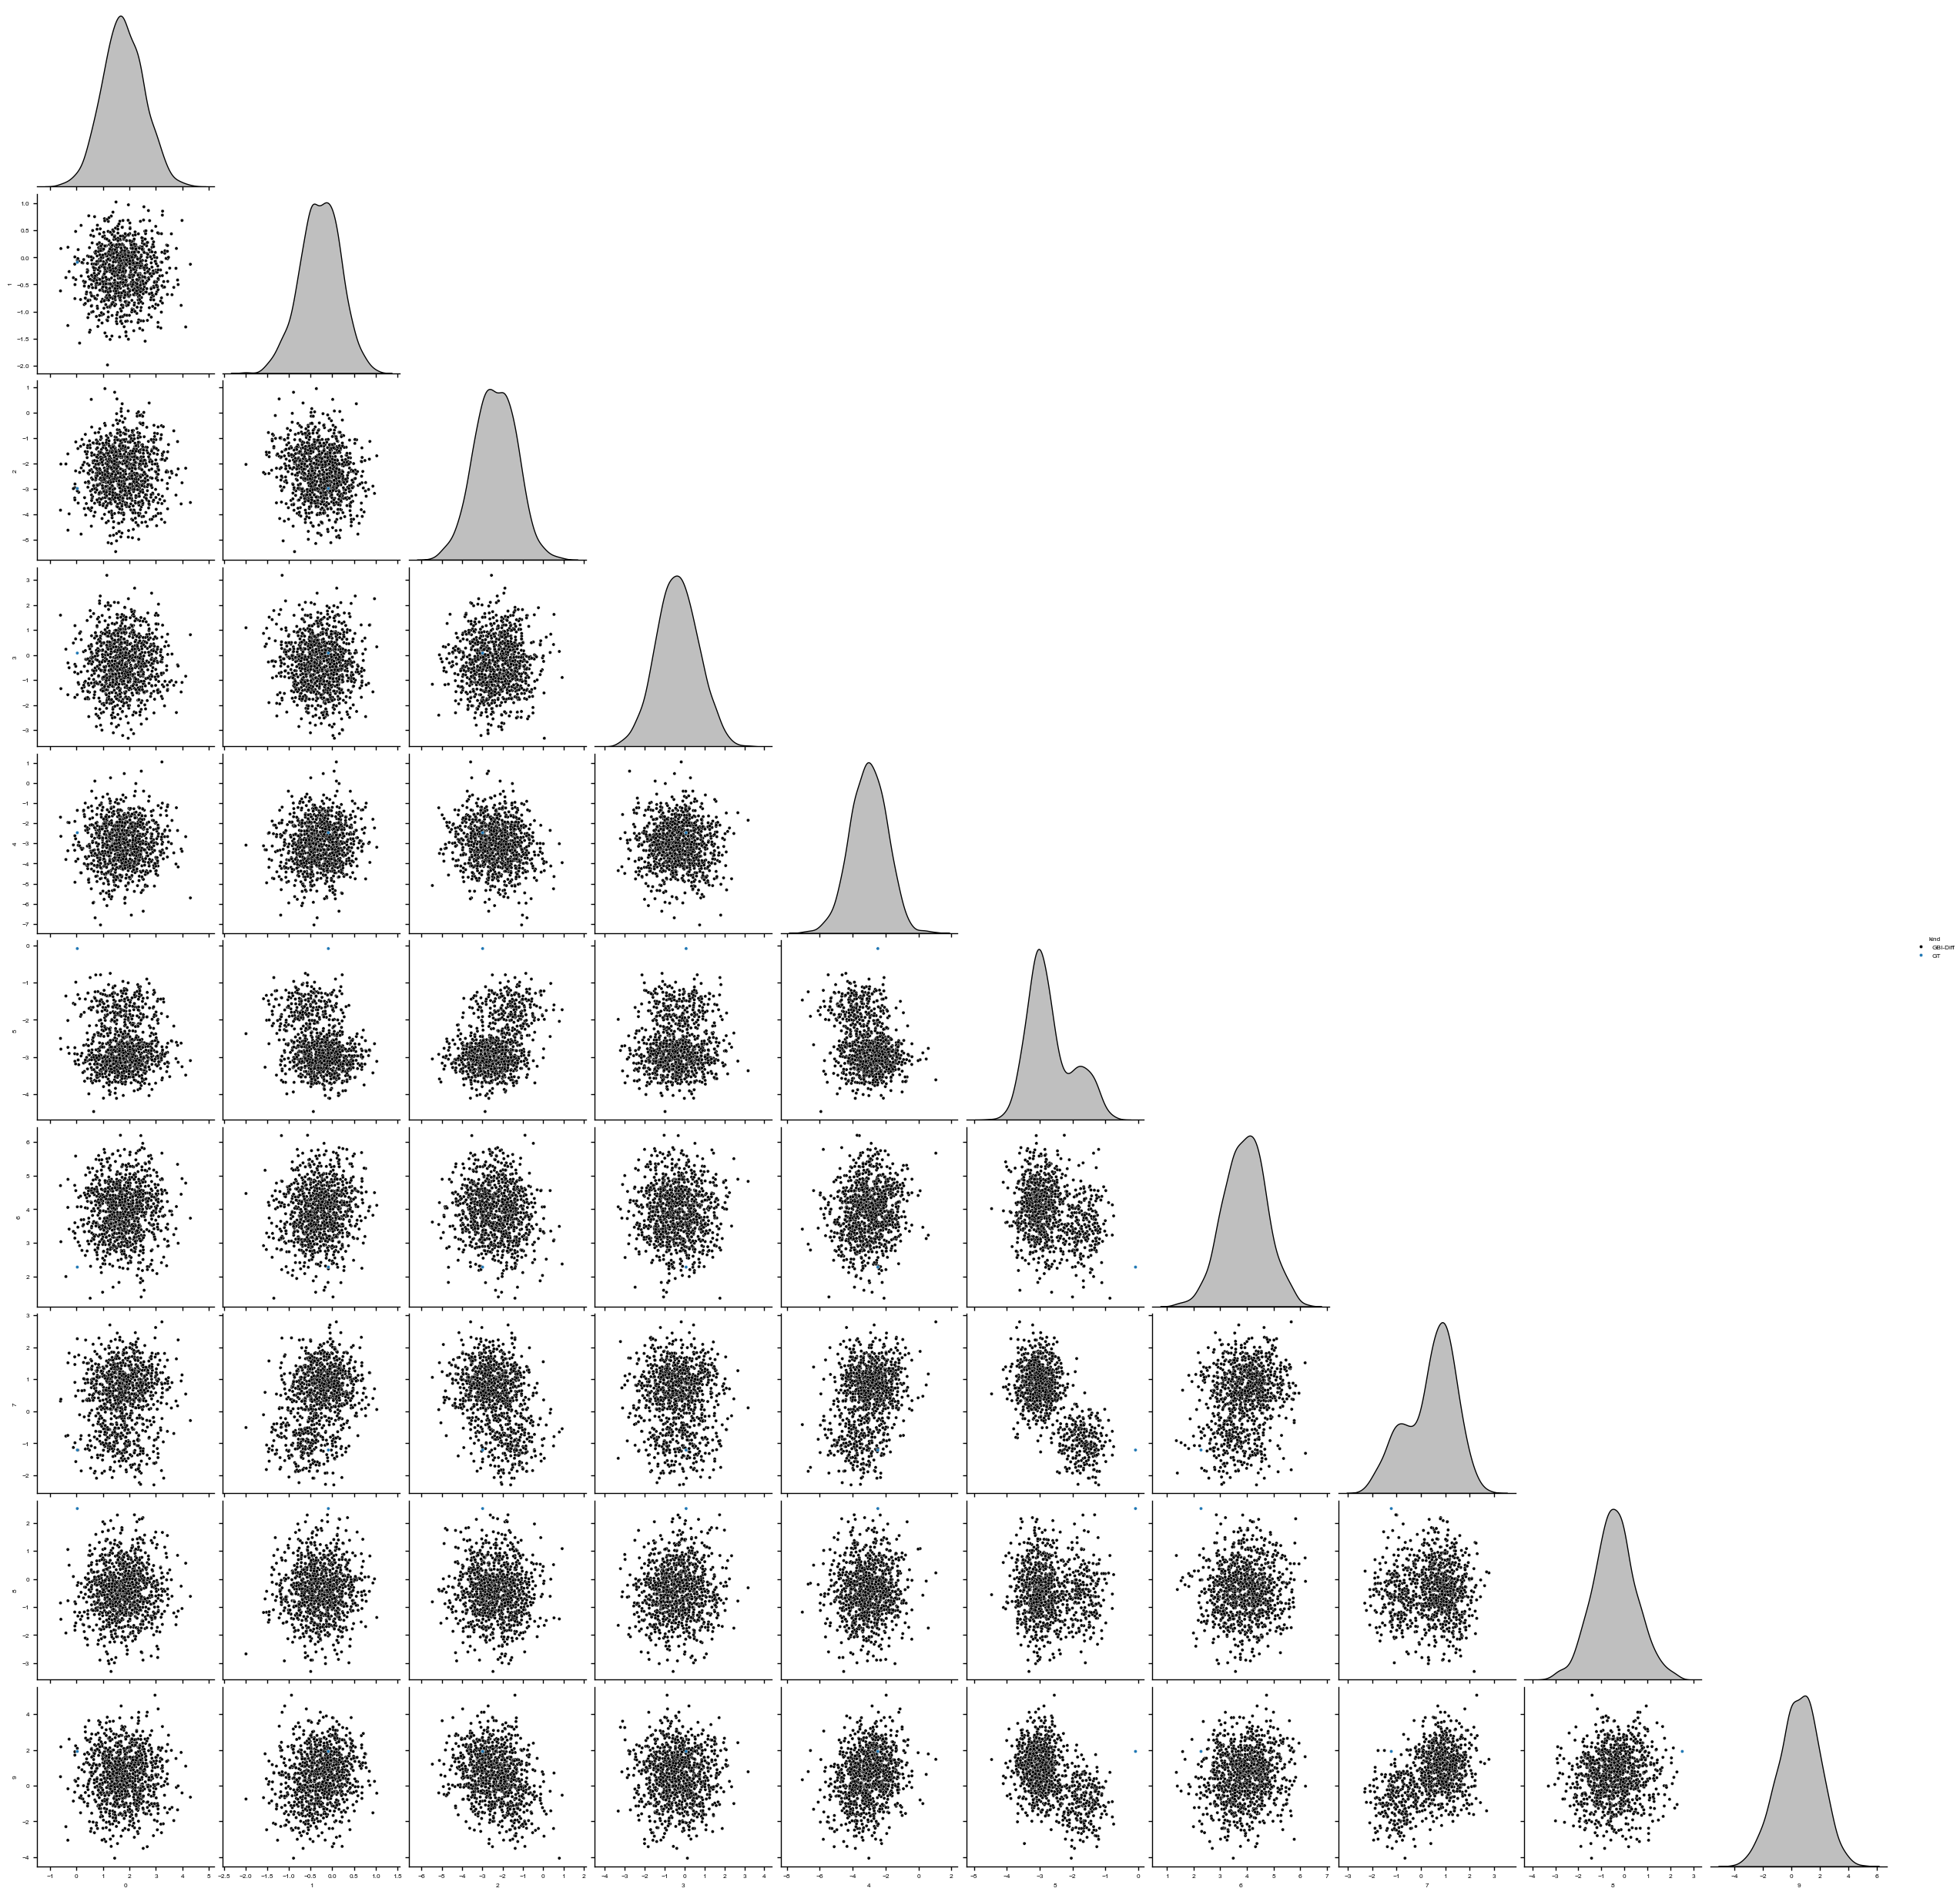

In [23]:
import seaborn as sns

df = pd.DataFrame(x_pred[-1].detach().numpy())
df["kind"] = "GBI-Diff"
df.loc[len(df)] = [*sampler.x_o[0].tolist(), "GT"]
print(df)
sns.pairplot(df, hue="kind", corner=True)

<Axes: ylabel='Density'>

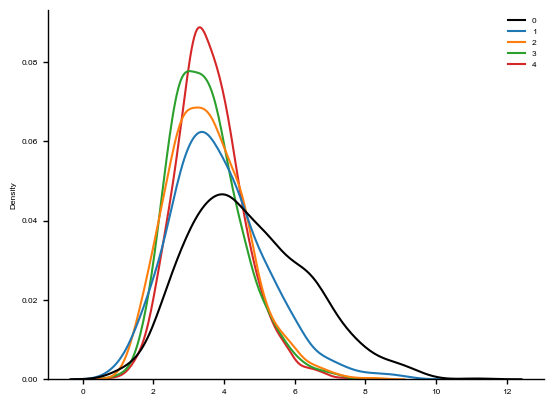

In [24]:
sns.kdeplot(pd.DataFrame(torch.mean(torch.square(x_pred - sampler.x_o[0]), dim=2).detach().numpy().T))